# Prerequisities

In [1]:
%load_ext autoreload
%autoreload 2

import json
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from data import (
    get_retina,
    get_skinlesion,
    standardize_retina_inv,
    standardize_skinlesion_inv,
)
from main import get_model
from matplotlib.lines import Line2D
from PIL import Image

# sns.set_style("whitegrid")

# Retina

## Load stats retina

In [2]:
models = ["CNN", "UNet"]
optimizers = ["adam", "sgd"]
loss_functions = ["bce_loss", "dice_loss", "focal_loss", "bce_total_variation"]
dataset = 'retina'

models_dir = '../models/retina'
json_files = []

for model_name in os.listdir(models_dir):
    model_dir = os.path.join(models_dir, model_name)
    if os.path.isdir(model_dir):
        stats_dir = os.path.join(model_dir, 'stats')
        if '.ipynb_checkpoints' in stats_dir:
            continue
        for file in os.listdir(stats_dir):
            if file.endswith('.json'):
                json_files.append(os.path.join(stats_dir, file))

json_files

['../models/retina/unet/stats/unet_24_adam_bce_total_variation.json',
 '../models/retina/unet/stats/unet_16_adam_bce_loss_augmented.json',
 '../models/retina/cnn/stats/cnn_24_adam_bce_loss_augmented.json']

In [3]:
stats_list = []
for fname in json_files:
    with open(fname, 'r') as f:
        stats_list.append(json.load(f))
stats = {s['model_name']: s for s in stats_list}
stats_list = None

stats.keys()

dict_keys(['unet_24_adam_bce_total_variation', 'unet_16_adam_bce_loss_augmented', 'cnn_24_adam_bce_loss_augmented'])

## Load models

In [4]:
# Check if cuda is available.
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f'Using device:\t{device}')

Using device:	cpu


In [5]:
checkpoint_dir = f'../models/{dataset}'
unetname = 'unet_24_adam_bce_total_variation'
# unetname = 'unet_16_adam_bce_loss_augmented'
statsunet = stats[unetname]
UNet = get_model(statsunet['model'], 3, (288, 288),
                 statsunet['n_features'], device=device)
msgunet = UNet.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'unet/checkpoints', unetname + '.pt')))

cnnname = 'cnn_24_adam_bce_loss_augmented'
statscnn = stats[cnnname]
CNN = get_model(statscnn['model'], 3, (288, 288),
                statscnn['n_features'], device=device)
msgcnn = CNN.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'cnn/checkpoints', cnnname + '.pt')))
msgunet, msgcnn

(<All keys matched successfully>, <All keys matched successfully>)

## Visualize predictions

In [6]:
folder = "sam_predictions/retina/"

images = sorted(os.listdir(folder))

preds_sam = []
for image in images:
    im = Image.open(folder + image)
    preds_sam.append(np.asarray(im))

In [7]:
# There are 4 images in the val/test set
_, _, _, _, val_loader, _ = get_retina(
    4,
    num_workers=0,
)

im_batch, labels = next(iter(val_loader))
im_batch, labels = im_batch.to(device), labels.to(device)
im_batch.size(), labels.size()

(torch.Size([4, 3, 288, 288]), torch.Size([4, 1, 288, 288]))

In [8]:
with torch.no_grad():
    preds_unet = torch.round(torch.sigmoid(UNet(im_batch)))
    preds_cnn = torch.round(torch.sigmoid(CNN(im_batch)))
preds_unet.size(), preds_cnn.size()

(torch.Size([4, 1, 288, 288]), torch.Size([4, 1, 288, 288]))

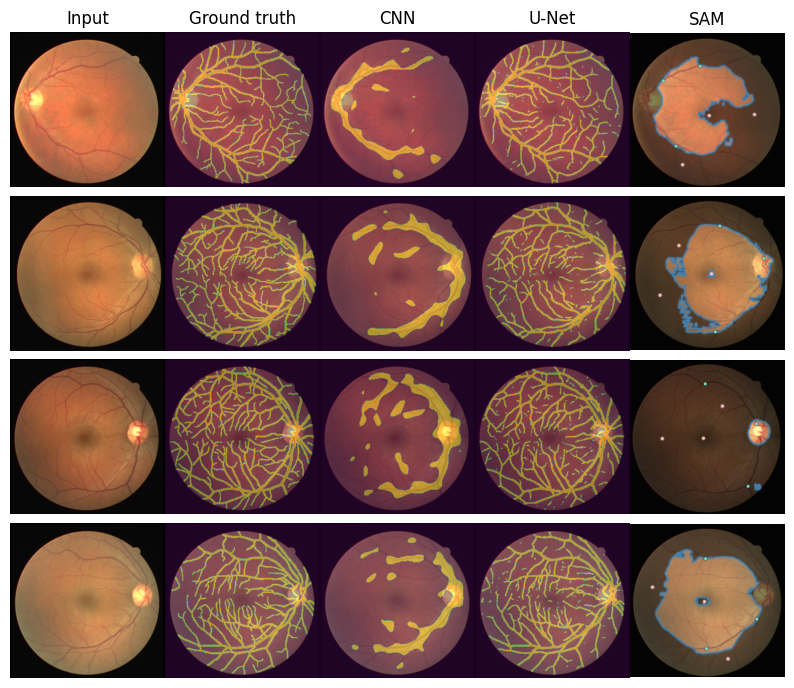

In [22]:
fig, axs = plt.subplots(4, 5, figsize=(10, 8.5))
fig.subplots_adjust(wspace=0.0, hspace=0.0)
titles = ['Input', 'Ground truth', 'CNN', 'U-Net', 'SAM']

for ax, title in zip(axs[0], titles):
    ax.set_title(title)

for i, (im, label, pred_unet,
        pred_cnn, pred_sam) in enumerate(zip(im_batch, labels, preds_unet, preds_cnn, preds_sam)):
    im = standardize_retina_inv(im)

    for ax in axs.ravel():
        ax.axis('off')

    for ax in axs[i]:
        ax.imshow(np.moveaxis(im.numpy(), 0, 2))
    _, ax1, ax2, ax3, ax4 = axs[i]

    ax1.imshow(label.numpy().astype(bool)[0], alpha=.4)
    ax2.imshow(pred_cnn.numpy().astype(bool)[0], alpha=.4)
    ax3.imshow(pred_unet.numpy().astype(bool)[0], alpha=.4)
    ax4.imshow(pred_sam[19:-19])
fig.savefig('../figs/retina_preds.png', bbox_inches='tight')

# Load stats

In [10]:
# models_dir = '../models'
# json_files = []

# for model_name in os.listdir(models_dir):
#     model_dir = os.path.join(models_dir, model_name)
#     if os.path.isdir(model_dir):
#         stats_dir = os.path.join(model_dir, 'stats')
#         if '.ipynb_checkpoints' in stats_dir:
#             continue
#         for file in os.listdir(stats_dir):
#             if file.endswith('.json'):
#                 json_files.append(os.path.join(stats_dir, file))

# json_files

In [11]:
# stats_list = []
# for fname in json_files:
#     with open(fname, 'r') as f:
#         stats_list.append(json.load(f))